In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

In [3]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [4]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [5]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [6]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [7]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [8]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [9]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(cataract),len(normal))

594 500


In [10]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [11]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:04<00:00, 138.19it/s]


In [12]:
len(dataset)

588

In [13]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:05<00:00, 90.88it/s] 


In [14]:
len(dataset)

1088

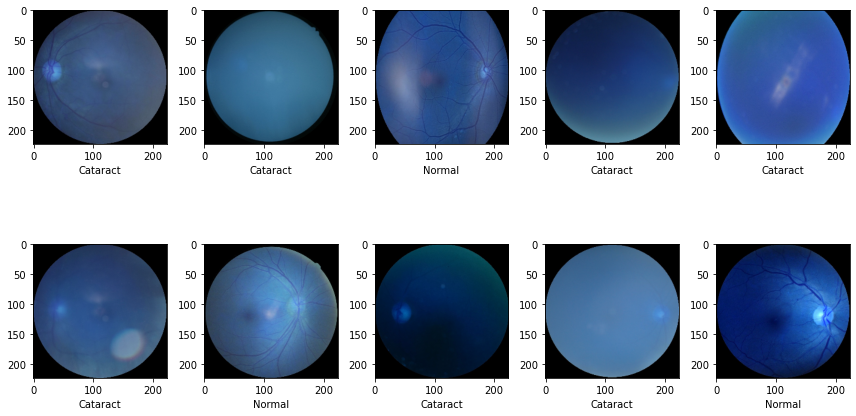

In [15]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [16]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.applications import DenseNet201

densenet = DenseNet201(weights="imagenet", input_shape=(224, 224, 3), include_top=False, pooling=max)

for layer in densenet.layers:
    layer.trainable = False

In [28]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization
x = Dropout(0.9)(densenet.output) # Add a dropout layer with a rate of 0.5
x = Flatten() (x)
x = BatchNormalization(axis=-1)(x) # Add a batch normalization layer
x = Dense(512, activation = 'sigmoid')(x)
x = BatchNormalization(axis=-1)(x) # Add a batch normalization layer
x = Dense(512, activation = 'sigmoid')(x)
x = BatchNormalization(axis=-1)(x) # Add a batch normalization layer
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.9)(x)
prediction = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = densenet.input, outputs = prediction)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [30]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("densenet201.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/50
28/28 [==============================] - 5s 188ms/step - loss: 0.0406 - accuracy: 0.9897 - val_loss: 0.3039 - val_accuracy: 0.9404
Epoch 2/50
28/28 [==============================] - 6s 199ms/step - loss: 0.0599 - accuracy: 0.9713 - val_loss: 0.4887 - val_accuracy: 0.9266
Epoch 3/50
28/28 [==============================] - 5s 189ms/step - loss: 0.0565 - accuracy: 0.9793 - val_loss: 0.2057 - val_accuracy: 0.9541
Epoch 4/50
28/28 [==============================] - 5s 190ms/step - loss: 0.1208 - accuracy: 0.9690 - val_loss: 0.4220 - val_accuracy: 0.9404
Epoch 5/50
19/28 [===================>..........] - ETA: 1s - loss: 0.0938 - accuracy: 0.9737

In [44]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 142ms/step - loss: 0.3591 - accuracy: 0.9404
loss: 0.35908934473991394
Accuracy: 0.9403669834136963


In [45]:
!pip install scikit-learn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [46]:
# Obtain the predicted probability values for the test data
y_pred = model.predict(x_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

In [47]:
accuracy_score(y_test,y_pred)

0.9403669724770642

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       114
           1       0.90      0.98      0.94       104

    accuracy                           0.94       218
   macro avg       0.94      0.94      0.94       218
weighted avg       0.94      0.94      0.94       218



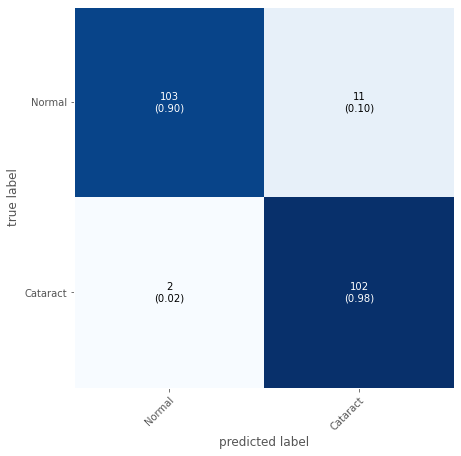

In [49]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

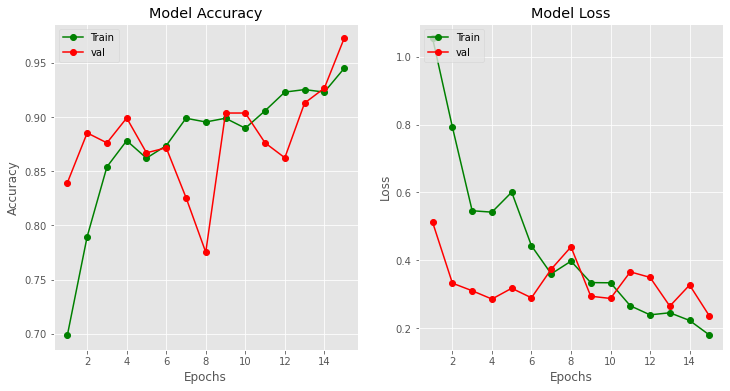

In [40]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()